In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Q4) Edge Detection
## Step I - Gaussian Blurring

In [3]:
def get_gaussian_kernel(size = (3, 3), sigma=1.):
    # unpack two components of size
    m, n = size
    # cast them to int, avoid float error
    m, n = int(m), int(n)
    # linspace to expand on coordinates for each dimension
    y = np.linspace(-m / 2, m / 2, m)
    x = np.linspace(-n / 2, n / 2, n)
    
    # meshgrid so we can evluate all positions at once
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-((x ** 2 + y ** 2) / (2. * sigma ** 2)))
    
    # normalize and return
    return kernel / np.sum(kernel)

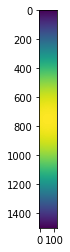

In [4]:
# sanity check
plt.imshow(get_gaussian_kernel(size = (1500, 1200), sigma = 500))

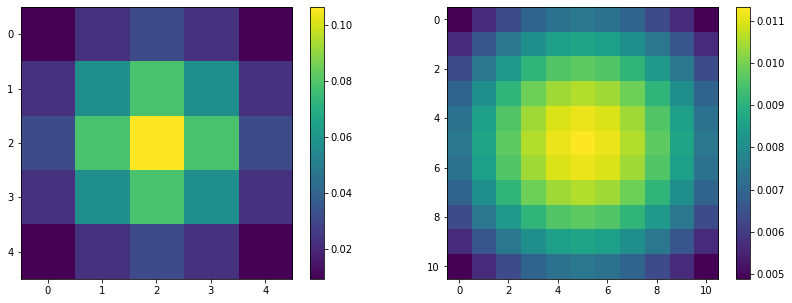

In [4]:
# make the visualization plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot1 = ax1.imshow(get_gaussian_kernel((5, 5), 1.6))
plot2 = ax2.imshow(get_gaussian_kernel((11, 11), 6))

fig.colorbar(plot1, ax=ax1)
fig.colorbar(plot2, ax=ax2)

# save as pdf
fig.savefig("./figs/q4step1.pdf", bbox_inches = 'tight', pad_inches = 0)

## Step II - Gradient Magnitde

In [5]:
def flip_both_sides(kernel):
    return np.fliplr(np.flipud(kernel))

In [6]:
box = np.arange(9).reshape(3, 3)
flip_both_sides(box)

array([[8, 7, 6],
       [5, 4, 3],
       [2, 1, 0]])

In [7]:
def pad_image(image, pad_sizex, pad_sizey):
    """
    input (m, n) image
    input pad_sizex, padding on left and right of the image
    input pad_sizey, padding on top and bottom of the image
    output (m + 2pad_sizey) x (n + 2pad_sizex) image, all padded with zero
    """
    return np.pad(image, [(pad_sizey, pad_sizey), (pad_sizex, pad_sizex)])

In [8]:
pad_image(box, 1, 3)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 2, 0],
       [0, 3, 4, 5, 0],
       [0, 6, 7, 8, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [9]:
def handle_kernel_even(kernel):
    k, k_ = kernel.shape
    
    # handle k is even case
    if k % 2 == 0:
        # log the info
        print(f"detected kernel has even y-direction size {k}, padding with zero at top to make y-size {k + 1}")
        # make the padding
        kernel = np.pad(kernel, [(1, 0), (0, 0)])
        
    # handle k_ is even case
    if k_ % 2 == 0:
        # log the info
        print(f"detected kernel has even x-direction size {k_}, padding with zero at left to make x-size {k_ + 1}")
        # make the padding
        kernel = np.pad(kernel, [(0, 0), (1, 0)])
        
    return kernel

In [10]:
def conv_full(image, kernel):
    """
    convolves kernel with image, padded so that output size = image size
    
    image I, size m x n numpy array
    kernel,  size k x k_ numpy array
    outputs  size m x n numpy array
    """
    # handle the case of even sized kernels 
    kernel = handle_kernel_even(kernel)
    
    # store padded kernel, assert should be odd sizes
    k, k_ = kernel.shape
    assert k % 2 == 1 and k_ % 2 == 1, "something went wrong! should already been handled!"
    
    # flip the kernel along both axies
    kernel = flip_both_sides(kernel)
    
    # zeros for storting conv results
    result = np.zeros(image.shape)
    
    # padding sizes for image, calculated based on the size of the kernel
    pad_sidey = int((k - 1) / 2)
    pad_sidex = int((k_ - 1) / 2)
    
    padded_image = pad_image(image, pad_sidex, pad_sidey)
    padded_m, padded_n = padded_image.shape
    # loop over vertical direction
    for j in range(pad_sidey, padded_m - pad_sidey):
        # loop over horizontal direction
        for i in range(pad_sidex, padded_n - pad_sidex):
            # selected matrix box to perform matrix dot with flipped kernel
            selected = padded_image[j - pad_sidey: j + pad_sidey + 1, 
                                    i - pad_sidex: i + pad_sidex + 1]
            ypos = j - pad_sidey
            xpos = i - pad_sidex
            # inner product between selected box, then sum and store
            result[ypos, xpos] = np.sum(selected * kernel)
    return result

detected kernel has even x-direction size 2, padding with zero at left to make x-size 3


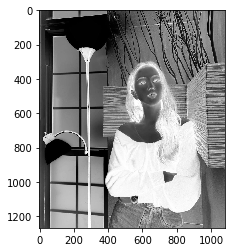

In [11]:
# sanity check, non square filter, containing one even side length :D
im = cv2.imread("./Q4_jisoo_2.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.imshow(conv_full(im, np.array([[-1, 0]])), cmap="gray")

In [12]:
def calc_grad_magnitude(
    image,
    gx = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ]),
    gy = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])):
    """
    calculate gradient magnitudes, using gx and gy as finite difference 
    gradeint convolution operators. Default Sobel Filters
    """
    return np.sqrt(
        conv_full(image, gx) ** 2 + conv_full(image, gy) ** 2
    )

In [13]:
box = np.arange(100).reshape(10, 10)


## Step III - Threshold Algorithm

In [14]:
def auto_threshold(image_grad_mag, eps=1e-8):
    #1. initial threshold
    h, w = image_grad_mag.shape
    image_num_slots = h * w
    
    taus = list()
    taus.append(np.sum(image_grad_mag) / image_num_slots)
    
    #2. set iterartion index 0 and seperate into two classes
    i = 0
    while (i == 0 or np.abs(taus[i] - taus[i - 1]) > eps):
        lower_class = image_grad_mag * (image_grad_mag < taus[i])
        upper_class = image_grad_mag * (image_grad_mag >= taus[i])
        
        #3. compute the average gradient values seperately
        ml = np.sum(lower_class) / np.sum(image_grad_mag < taus[i])
        mh = np.sum(upper_class) / np.sum(image_grad_mag >= taus[i])

        #4. update i <-- i + 1
        i += 1
        taus.append((ml + mh) / 2)
        
    #5. the last tau is what we want
    tau = taus[-1]
    
    # apply the thresholding, start with all 255, we will sift out zero
    result = np.ones((h, w)) * 255
    
    # mask the mask onto the results
    result = result * [image_grad_mag >= tau]
    return result.squeeze()

## Step IV - Test

In [15]:
# import time

def get_edges(
    filename="Q4_image_1.jpg",
    kernel=get_gaussian_kernel(),
    thres_eps=1e-2):
    
    image = cv2.imread(filename)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = conv_full(image_gray, kernel)
    
    gradient_magnitude = calc_grad_magnitude(blurred_image)
    thresholded = auto_threshold(gradient_magnitude, eps=thres_eps)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    gray_plot = ax1.imshow(gradient_magnitude, cmap="gray")
    binary_plot = ax2.imshow(thresholded, cmap="gray")
    
    fig.savefig("./figs/q4test" + filename + ".pdf", 
                bbox_inches = 'tight', pad_inches = 0)

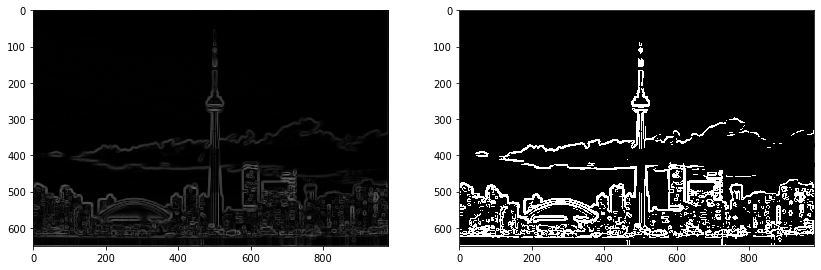

In [16]:
# Q4_image_1.jpg, gaussian blur of 7 x 7, sigma = 9, threshold eps = 1e-2
get_edges(kernel=get_gaussian_kernel((7, 7), 9), thres_eps=1e-2)

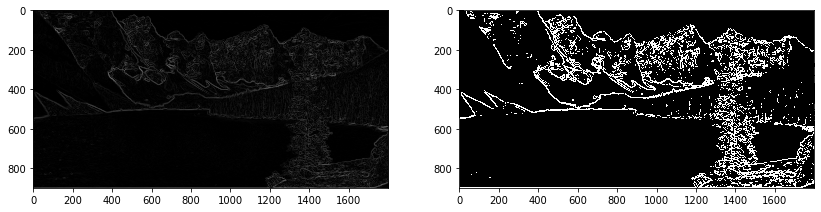

In [17]:
# Q4_image_2.jpg with 
# gaussian blur of 7 x 7, sigma = 9, threshold eps = 1e-2
get_edges(filename="Q4_image_2.jpg", kernel=get_gaussian_kernel((7, 7), 9))

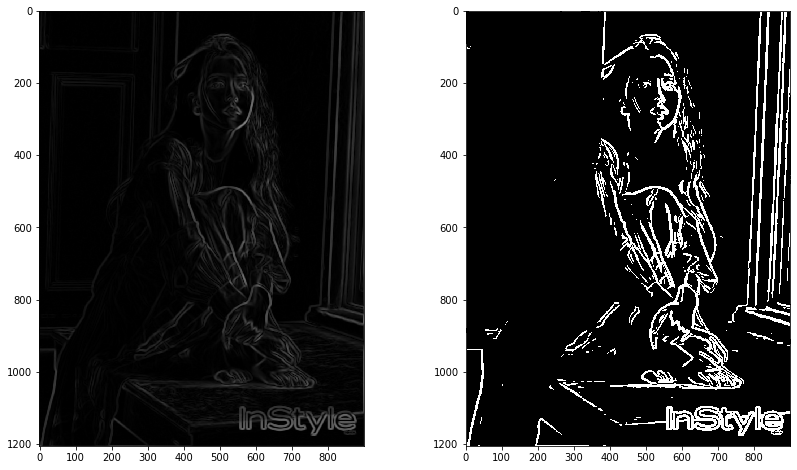

In [18]:
# Q4_kim_jisoo.jpeg with
# gaussian blur of 7 x 7, sigma = 9, threshold eps = 1e-2
get_edges(filename="Q4_kim_jisoo.jpeg", kernel=get_gaussian_kernel((7, 7), 9))

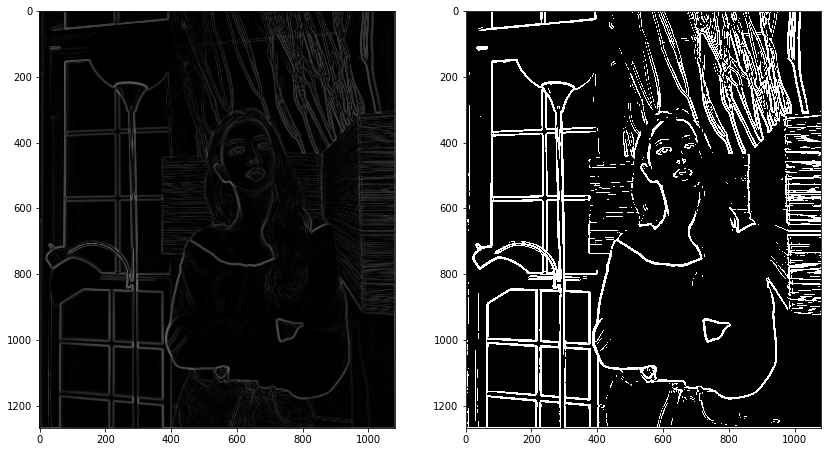

In [19]:
# just something else that I chose to try on my own lol
# gaussian blur of 7 x 7, sigma = 9, threshold eps = 1e-2
get_edges(filename="Q4_jisoo_2.jpg", kernel=get_gaussian_kernel((7, 7), 9))

# Q5) Connected-component Labeling

In [20]:
# simple queue class for Question 5 CCL
class Queue:
    def __init__(self):
        self.queue = []
        
    def is_empty(self):
        return len(self.queue) == 0
    
    def push(self, element):
        self.queue.append(element)
        
    def pop(self):
        if not self.is_empty():
            return self.queue.pop(0)
        return None

In [21]:
# 255 is white, and 0 is black
# black back ground and white foreground

In [22]:
def connected_comp_lab(image):
    height, width = image.shape
    FOREGROUND = 255
    BACKGROUND = 0
    
    # start with all zero, zero means not labeled; actual label will start from 1
    labeled_map = np.zeros_like(image)
    cur_label = 1
    
    # make a queue instance
    q = Queue()
    
    # main loop, looping over all pixels
    for i in range(width):
        for j in range(height):
            pix = image[j, i] # reversed indexing in numpy
            pix_label = labeled_map[j, i]
            if pix == FOREGROUND and not pix_label:
                # set to current label
                labeled_map[j, i] = cur_label
                # put inside queue
                q.push((j, i))
                # repeat until the queue is empty
                while (not q.is_empty()):
                    # take an element out
                    poped_pos_y, poped_pos_x = q.pop()
                    # look at its neighbours
                    for n in range(poped_pos_y - 1, poped_pos_y + 2):
                        for m in range(poped_pos_x - 1, poped_pos_x + 2):
                            # make sure still valid position, and not the center position avoid double count
                            if m >= 0 and n >= 0 and m < width and n < height and (m, n) != (poped_pos_x, poped_pos_y):
                                # if not lablled and foreground
                                if not labeled_map[n, m] and image[n, m] == FOREGROUND:
                                    # give it the current label
                                    labeled_map[n, m] = cur_label
                                    # and add to the queue
                                    q.push((n, m))
                cur_label += 1
    return labeled_map

In [23]:
# sanity check
box = np.array([
    [  0, 255, 255],
    [  0,   0, 255],
    [255,   0,   0]]
)
connected_comp_lab(box)

array([[0, 2, 2],
       [0, 0, 2],
       [1, 0, 0]])

# 6) Count the Number of Cells

There are 32.0 cells in total (estimated) in the image
took 0.5104949474334717s to run


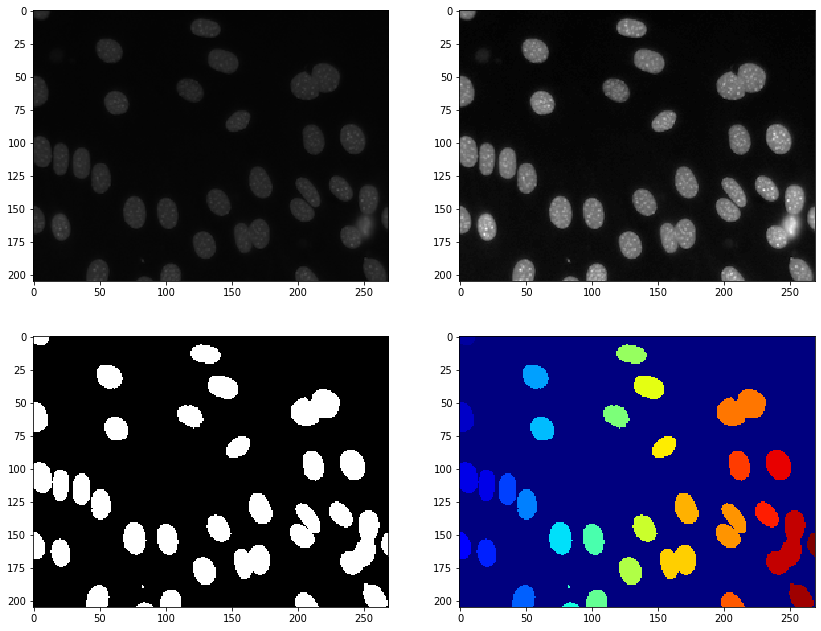

In [24]:
def report_num_cells(filename="./Q6.png"):
    cell_image_original = cv2.imread(filename)
    cell_image = cv2.cvtColor(cell_image_original, cv2.COLOR_BGR2GRAY)

    thresholded = auto_threshold(cell_image, eps=1.)
    labels = connected_comp_lab(thresholded)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 11))
    ax1.imshow(cell_image_original)
    ax2.imshow(cell_image, cmap="gray")
    ax3.imshow(thresholded, cmap="gray")
    ax4.imshow(labels, cmap=plt.cm.jet)
    
    fig.savefig("./figs/q6cells.pdf", bbox_inches = 'tight', pad_inches = 0)
    
    print(f"There are {np.max(labels)} cells in total (estimated) in the image")

    
import time
time1 = time.time()
report_num_cells()
print(f"took {time.time() - time1}s to run")